In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

# from sqlalchemy import create_engine, inspect 
inspector = inspect(engine)
print(inspector.get_table_names())
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
columns = inspector.get_columns('station')
print("--------------")
for column in columns:
    print(column["name"], column["type"])


['measurement', 'station']
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
--------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
stationEng = engine.execute("SELECT * FROM station")  # .fetchall() to visual see
measurementEng = engine.execute("SELECT * FROM measurement")


<class 'str'>
('2017-08-23',)
["('2017", '08', "23',)"]


Text(0, 0.5, 'precipitation (inches)')

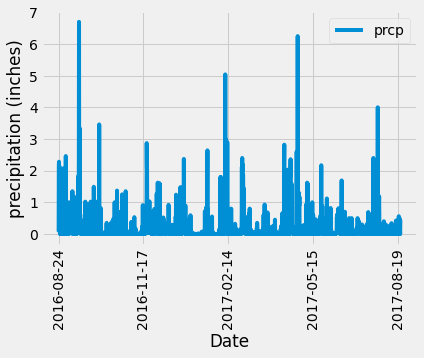

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date =  session.query(func.max(Measurement.date)).first()
max_date = str(max_date)
print(type(max_date))
max_date_split = max_date.split('-')
print(max_date)
print(max_date_split)
# Calculate the date 1 year ago from the last data point in the database
minus_year = str(dt.date(2017, 8, 23) - dt.timedelta(days=365))
#minus_year = str(dt.date(int(max_date_split[0]), int(max_date_split[1]), int(max_date_split[2])) - dt.timedelta(days=365))

# Perform a query to retrieve the date and precipitation scores
###  results for the last year of data (note that the last day in the dataset is 8/23/2017)
precipitation = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > minus_year)\
     .filter(Measurement.prcp>=0).order_by(Measurement.date).all()
# to pull the entire table useprecipitation_df = pd.DataFrame(precipitation)

# measurement_df = pd.read_sql_table('measurement',engine)

# Save the query results as a Pandas DataFrame and set the index to the date column
### Creates a pandas dataframe using the date and precipitation columns
# conn = engine.connect()
# precipitation_df = pd.read_sql("SELECT date, prcp FROM measurement WHERE date > minus_year", conn)


precipitation_df = pd.DataFrame(precipitation)
### Sorts the dataframe by date
precipitation_df = precipitation_df.sort_values(by=['date'],ascending=True) 
precipitation_df = precipitation_df.set_index('date')

# station_df = pd.read_sql_table('station',engine)
precipitation_df.plot(rot=90)

# Use Pandas Plotting with Matplotlib to plot the data
### Makes a plot using pandas with date as the x and precipitation as the y variables

# prcp = [prec[1]for prec in precipitation]
date = [prec[0]for prec in precipitation]
# plt.bar(date,prcp)
plt.xlabel('Date')
plt.ylabel('precipitation (inches)')

# plt.figure(figsize=(50,30))
# plt.tight_layout()
# plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data = pd.read_sql("SELECT prcp FROM measurement", con = engine)
# measurement_df = pd.read_sql_table('measurement',engine)
precipitation_data.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [14]:
# Design a query to show how many stations are available in this dataset? 
### Correctly outputs the number of stations in the dataset (9)

stations_d = session.query(Station).count() 
stations_d

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
###  Correctly finds the most active station by using count (USC00519281)

measurement_df = pd.read_sql_table('measurement',engine)
# station_df = pd.read_sql_table('station', engine)
measurement_gp = measurement_df.groupby("station")['id'].count()
measurement_gp = measurement_gp.reset_index()
measurement_gp = measurement_gp.rename(columns={"id":"count"})
measurement_gp = measurement_gp.sort_values(["count"], ascending=False)
station_max = measurement_gp.iloc[0,0]
measurement_gp



,station,count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#You will need to use a function such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.
# session.query(self.stats.c.ID, func.max(self.stats.c.STA_DATE))
### Gets the min, max, and average temperatures for the most active station (USC00519281) station_max = measurement_gp.iloc[0,0]

# min_temp = session.query(precipitation_df)\
#     .filter(Measurement.date >= minus_year)\
#     .order_by(Measurement.tobs)\
#     .first()

min_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.station == station_max).all() #filter(Measurement.station = station_max).first()
print(f"Min Temp: {min_temp[0][0]}")
print(f"Max Temp: {min_temp[0][1]}")
print(f"Avg Temp: {round(min_temp[0][2],2)}")

Min Temp: 54.0
Max Temp: 85.0
Avg Temp: 71.66


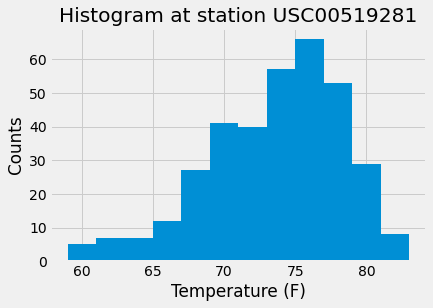

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Plot the results as a histogram with `bins=12`.
### Correctly plots a histogram for the last year of data using tobs as the column to count.

temp_query = session.query(Measurement.tobs).filter(Measurement.date >= minus_year)\
    .filter(Measurement.tobs>=0).filter(Measurement.station== station_max).all()

temp_data = [temp[0]for temp in temp_query]
plt.hist(temp_data, bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Counts')
title1= f'Histogram at station {station_max}'
plt.title(title1)
plt.show()



## Bonus Challenge Assignment

In [48]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

min_date = input("what is the starting date inclusive (ex:2016-05-05): ")
max_date = input("what is the end date inclusive (ex:2016-05-20): ")

# function usage example
temp_stats = calc_temps(min_date, max_date)
print(f"Min Temp: {temp_stats[0][0]}")
print(f"Avg Temp: {round(temp_stats[0][1],2)}")
print(f"Max Temp: {round(temp_stats[0][2],2)}")

what is the starting date inclusive (ex:2016-05-05): 2016-05-05
what is the end date inclusive (ex:2016-05-20): 2016-05-20
Min Temp: 65.0
Avg Temp: 73.53
Max Temp: 79.0


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# !!!! need to adjust for leap year
year_min = min_date.split('-')
year_max = max_date.split('-')
last_min = dt.date(int(year_min[0]),int(year_min[1]), int(year_min[2])) - dt.timedelta(days=365)
last_max = dt.date(int(year_max[0]),int(year_max[1]), int(year_max[2])) - dt.timedelta(days=365)

temp_stats = calc_temps(last_min, last_max)
print("The previous years stats are:")
print(f"Min Temp: {temp_stats[0][0]}")
print(f"Avg Temp: {round(temp_stats[0][1],2)}")
print(f"Max Temp: {round(temp_stats[0][2],2)}")


print("From day:", last_min)
print("To day:", last_max)

The previous years stats are:
Min Temp: 65.0
Max Temp: 73.62
Avg Temp: 82.0
From day: 2015-05-06
To day: 2015-05-21


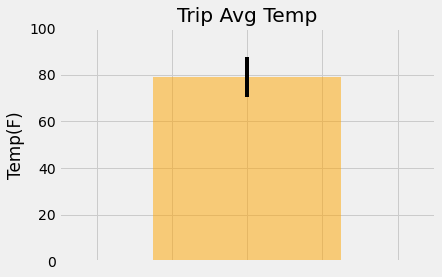

In [96]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x = 0
avg_temp = temp_stats[0][2]
error = temp_stats[0][1]-temp_stats[0][0]
plt.close('all')
plt.bar(x,avg_temp, color="orange", alpha=0.5, width=0.025)
plt.errorbar(x, avg_temp, error, ecolor="black")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    labelbottom=False) 
plt.xlim(-0.025,0.025)
plt.ylim(0, 100)
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.show()


In [47]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_date = session.query(Measurement.station, Measurement.prcp).\
        filter(Measurement.date >= last_min).filter(Measurement.date <= last_max).all()
rain_df = pd.DataFrame(rain_date)
rain_df = rain_df.groupby("station")['prcp'].sum()

rain_df = rain_gp.reset_index()
rain_df = rain_gp.sort_values(["prcp"], ascending=False)

station_data = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_df = pd.DataFrame(station_data)
station_df
merge_df = pd.merge(rain_df, station_df, on='station')
merge_df

,station,prcp,name,latitude,longitude,elevation
0,USC00516128,6.37,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,1.82,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,0.77,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,0.64,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519397,0.41,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00519523,0.30,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00511918,0.09,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
7,USC00518838,0.00,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6


In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [62]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
min_date = input("what is the starting date inclusive (ex:2016-05-05): ")
max_date = input("what is the end date inclusive (ex:2016-05-20): ")

# Use the start and end date to create a range of dates
min_date = min_date.split('-')
max_date = max_date.split('-')
min_date = dt.date(int(min_date[0]),int(min_date[1]), int(min_date[2]))
max_date = dt.date(int(max_date[0]),int(max_date[1]), int(max_date[2]))
date_range = []
while min_date < max_date:
    min_date += dt.timedelta(days=1)
    print(min_date)
    # Strip off the year and save a list of %m-%d strings
    date_split = min_date.split('-')
    date_range=[date_split[1],date_split[2]]


# Loop through the list of %m-%d strings and calculate the normals for each date
# normals= []
# for day in dates

what is the starting date inclusive (ex:2016-05-05): 2016-05-20
what is the end date inclusive (ex:2016-05-20): 2016-06-20
2016-05-21
2016-05-22
2016-05-23
2016-05-24
2016-05-25
2016-05-26
2016-05-27
2016-05-28
2016-05-29
2016-05-30
2016-05-31
2016-06-01
2016-06-02
2016-06-03
2016-06-04
2016-06-05
2016-06-06
2016-06-07
2016-06-08
2016-06-09
2016-06-10
2016-06-11
2016-06-12
2016-06-13
2016-06-14
2016-06-15
2016-06-16
2016-06-17
2016-06-18
2016-06-19
2016-06-20


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
